### BPIC 2020 - generated interpretations


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from data.processor import *
from data.args import *

from tensorflow.keras.utils import to_categorical


### Define the experiment parameters

In [2]:
milestone = 'Request For Payment APPROVED by ADMINISTRATION' #,'All'
experiment =  'OHE'#'Standard'#'OHE', 'No_loops'
timelapsed = 'total' #'total', 'incremental'
n_size = 5

### Setting up the key parameters


In [3]:
# For local environment only

MY_WORKSPACE_DIR = os.path.join(os.getcwd(),'BPIC20')
MILESTONE_DIR = os.path.join(os.path.join(MY_WORKSPACE_DIR, milestone),experiment)

In [4]:
args = get_parameters('bpic20', MILESTONE_DIR, MY_WORKSPACE_DIR, milestone, experiment,n_size)


### Data Preprocessing

In [5]:
if milestone == 'All':
  log_df = pd.read_csv(args['file_name_all'])
  log_df = log_df.reset_index(drop=True)
else:
  log_df = pd.read_csv(args['file_name_all'])
  log_df = log_df.reset_index(drop=True)

if timelapsed == 'incremental':
  log_df['timelapsed'] = log_df['timelapsed_2']

log_df.head()

,prefix_id,caseid,end_timestamp,task,next_activity,prefix_length,task_index,trace_start,timelapsed,milestone,role,time:timestamp,org:resource,concept:name,id
0,request for payment 148214_1,request for payment 148214,2017-01-09 09:17:18+01:00,Request For Payment SUBMITTED by EMPLOYEE,Request For Payment FINAL_APPROVED by SUPERVISOR,1,6,2017-01-09 09:17:18+01:00,0,NaN,EMPLOYEE,2017-01-09 09:17:18+01:00,STAFF MEMBER,Request For Payment SUBMITTED by EMPLOYEE,st_step 148220_0
1,request for payment 148214_2,request for payment 148214,2017-01-09 09:17:18+01:00,Request For Payment SUBMITTED by EMPLOYEE,Request For Payment REJECTED by MISSING,2,6,2017-01-09 09:17:18+01:00,0,NaN,EMPLOYEE,2017-01-09 09:17:18+01:00,STAFF MEMBER,Request For Payment SUBMITTED by EMPLOYEE,st_step 148220_0
2,request for payment 148214_2,request for payment 148214,2017-01-09 09:18:00+01:00,Request For Payment FINAL_APPROVED by SUPERVISOR,Request For Payment REJECTED by MISSING,2,10,2017-01-09 09:17:18+01:00,0,NaN,SUPERVISOR,2017-01-09 09:18:00+01:00,STAFF MEMBER,Request For Payment FINAL_APPROVED by SUPERVISOR,st_step 148221_0
3,request for payment 148214_3,request for payment 148214,2017-01-09 09:17:18+01:00,Request For Payment SUBMITTED by EMPLOYEE,Request For Payment SUBMITTED by EMPLOYEE,3,6,2017-01-09 09:17:18+01:00,0,NaN,EMPLOYEE,2017-01-09 09:17:18+01:00,STAFF MEMBER,Request For Payment SUBMITTED by EMPLOYEE,st_step 148220_0
4,request for payment 148214_3,request for payment 148214,2017-01-09 09:18:00+01:00,Request For Payment FINAL_APPROVED by SUPERVISOR,Request For Payment SUBMITTED by EMPLOYEE,3,10,2017-01-09 09:17:18+01:00,0,NaN,SUPERVISOR,2017-01-09 09:18:00+01:00,STAFF MEMBER,Request For Payment FINAL_APPROVED by SUPERVISOR,st_step 148221_0


Milestone Extraction

We expect to filter the prefixes by the milestone, and train the model for each milestone separately to observe if there will be an improvement in the model explainability as well as performance


In [6]:
if milestone != 'All':
  log_df = log_df[log_df['milestone'] == milestone]

#### Data Analysis

In [7]:
#Checking the Balance of the Dataset, by the target variable
print('Distribution of cases by the target variable - next event\n')
print(log_df.groupby(['next_activity'])['prefix_id'].nunique())

Distribution of cases by the target variable - next event

next_activity
Payment Handled                                        1
Request For Payment APPROVED by BUDGET OWNER        2014
Request For Payment APPROVED by SUPERVISOR            19
Request For Payment FINAL_APPROVED by SUPERVISOR    3312
Request For Payment REJECTED by BUDGET OWNER          47
Request For Payment REJECTED by SUPERVISOR            95
Name: prefix_id, dtype: int64


In [8]:
#removing a minority target
log_df = log_df.drop(log_df[log_df.next_activity == 'Payment Handled'].index)

Reduce Loops

Function : `reduce_loops(df)`, Author: Manuel Camargo, Edited by: Bemali Wickramanayake

In [9]:
if experiment == 'No_Loops':
  log_df = reduce_loops(log_df)

#### Data Encoding and Vectorization

Index creating for data encoding
Function : `create_index(log_df, column)`, Author: Manuel Camargo, Edited by: Bemali Wickramanayake

In [10]:
# Index creation for activity

ac_index = create_index(log_df, 'task')
index_ac = {v: k for k, v in ac_index.items()}

# Index creation for unit

rl_index = create_index(log_df, 'role')
index_rl = {v: k for k, v in rl_index.items()}

# Index creation for next activity

ne_index = create_index(log_df, 'next_activity')

index_ne = {v: k for k, v in ne_index.items()}

#mapping the dictionary values as columns in the dataframe
log_df['ac_index'] = log_df['task'].map(ac_index)
log_df['rl_index'] = log_df['role'].map(rl_index)
log_df['ne_index'] = log_df['next_activity'].map(ne_index)

print(rl_index)
print(index_rl)
log_df.head()

{'none': 0, 'ADMINISTRATION': 1, 'BUDGET OWNER': 2, 'EMPLOYEE': 3, 'SUPERVISOR': 4}
{0: 'none', 1: 'ADMINISTRATION', 2: 'BUDGET OWNER', 3: 'EMPLOYEE', 4: 'SUPERVISOR'}


,prefix_id,caseid,end_timestamp,task,next_activity,prefix_length,task_index,trace_start,timelapsed,milestone,role,time:timestamp,org:resource,concept:name,id,ac_index,rl_index,ne_index
8484,request for payment 157874_5,request for payment 157874,2017-12-06 08:34:12+01:00,Request For Payment SUBMITTED by EMPLOYEE,Request For Payment FINAL_APPROVED by SUPERVISOR,5,6,2017-12-06 08:34:12+01:00,0,Request For Payment APPROVED by ADMINISTRATION,EMPLOYEE,2017-12-06 08:34:12+01:00,STAFF MEMBER,Request For Payment SUBMITTED by EMPLOYEE,st_step 157879_0,7,3,2
8485,request for payment 157874_5,request for payment 157874,2018-02-14 10:38:40+01:00,Request For Payment REJECTED by ADMINISTRATION,Request For Payment FINAL_APPROVED by SUPERVISOR,5,3,2017-12-06 08:34:12+01:00,1682,Request For Payment APPROVED by ADMINISTRATION,ADMINISTRATION,2018-02-14 10:38:40+01:00,STAFF MEMBER,Request For Payment REJECTED by ADMINISTRATION,st_step 157881_0,3,1,2
8486,request for payment 157874_5,request for payment 157874,2018-02-15 14:26:04+01:00,Request For Payment REJECTED by EMPLOYEE,Request For Payment FINAL_APPROVED by SUPERVISOR,5,7,2017-12-06 08:34:12+01:00,1709,Request For Payment APPROVED by ADMINISTRATION,EMPLOYEE,2018-02-15 14:26:04+01:00,STAFF MEMBER,Request For Payment REJECTED by EMPLOYEE,st_step 157880_0,5,3,2
8487,request for payment 157874_5,request for payment 157874,2018-03-28 08:50:44+02:00,Request For Payment SUBMITTED by EMPLOYEE,Request For Payment FINAL_APPROVED by SUPERVISOR,5,6,2017-12-06 08:34:12+01:00,2687,Request For Payment APPROVED by ADMINISTRATION,EMPLOYEE,2018-03-28 08:50:44+02:00,STAFF MEMBER,Request For Payment SUBMITTED by EMPLOYEE,st_step 157877_0,7,3,2
8488,request for payment 157874_5,request for payment 157874,2018-03-28 08:50:53+02:00,Request For Payment APPROVED by ADMINISTRATION,Request For Payment FINAL_APPROVED by SUPERVISOR,5,4,2017-12-06 08:34:12+01:00,2687,Request For Payment APPROVED by ADMINISTRATION,ADMINISTRATION,2018-03-28 08:50:53+02:00,STAFF MEMBER,Request For Payment APPROVED by ADMINISTRATION,st_step 157876_0,1,1,2


In [11]:
print(ne_index)

{'Request For Payment APPROVED by BUDGET OWNER': 0, 'Request For Payment APPROVED by SUPERVISOR': 1, 'Request For Payment FINAL_APPROVED by SUPERVISOR': 2, 'Request For Payment REJECTED by BUDGET OWNER': 3, 'Request For Payment REJECTED by SUPERVISOR': 4}


Splitting the dataframe into test and train sets

Function : `split_train_test(df, percentage)`, Author: Bemali Wickramanayake

In [12]:
# Split validation datasets
log_df_train, log_df_test = split_train_test(log_df, 0.3) # 70%/30%

Normalize Numerical Features

Function : `normalize_events(log_df,args,numerical_features)`, Author: Manuel Camargo, Edited by: Bemali Wickramanayake


In [13]:
numerical_features = ['timelapsed']
log_df_train = normalize_events(log_df_train,args,numerical_features)
log_df_test = normalize_events(log_df_test,args,numerical_features)


In [14]:
training_traces = len(log_df_train['prefix_id'].unique())
test_traces = len(log_df_test['prefix_id'].unique())


print('Number of traces in training set is:'+str(training_traces))
print('Number of traces in test set is:'+str(test_traces))


Number of traces in training set is:3841
Number of traces in test set is:1646


In [15]:
#Checking the Balance of the Dataset, by the target variable
print('training dataset')
print(log_df_train.groupby(['next_activity'])['prefix_id'].nunique())
print("")
print('test dataset')
print(log_df_test.groupby(['next_activity'])['prefix_id'].nunique())
print("")



training dataset
next_activity
Request For Payment APPROVED by BUDGET OWNER        1388
Request For Payment APPROVED by SUPERVISOR            13
Request For Payment FINAL_APPROVED by SUPERVISOR    2351
Request For Payment REJECTED by BUDGET OWNER          34
Request For Payment REJECTED by SUPERVISOR            55
Name: prefix_id, dtype: int64

test dataset
next_activity
Request For Payment APPROVED by BUDGET OWNER        626
Request For Payment APPROVED by SUPERVISOR            6
Request For Payment FINAL_APPROVED by SUPERVISOR    961
Request For Payment REJECTED by BUDGET OWNER         13
Request For Payment REJECTED by SUPERVISOR           40
Name: prefix_id, dtype: int64



Reformat events: converting the dataframe into a dictionary to aid vectorization

Function : `reformat_events(log_df, ac_index, rl_index,ne_index)`, Author: Renuka Sindagatta/ Manuel Camargo, Edited by: Bemali Wickramanayake




In [16]:
log_train = reformat_events(log_df_train, ac_index, rl_index,ne_index)
log_test = reformat_events(log_df_test, ac_index, rl_index,ne_index)
#log_val = reformat_events(log_df_val, ac_index, rl_index,ne_index)

#print a sample of the dictionary
print(log_train[200])

{'caseid': 'request for payment 161442_5', 'ac_order': [5, 7, 7, 1, 3], 'rl_order': [3, 3, 3, 1, 1], 'tbtw': [0.45860839883620025, 3.432703237307762, -0.41704036899183217, 3.432703237307762, -0.41704036899183217], 'next_activity': 0}


Vectorization: Convert the data dictionaries into trainable multi dimensional tensors

Function: `vectorization(log,ac_index, rl_index, ne_index,trc_len,cases)` , Author: Bemali Wickramanayake, Inspired by the code of: Renuka Sindagatta





In [17]:
#Obtain the maximum trc_len and cases for each set

trc_len_train, cases_train = lengths(log_train)
trc_len_test, cases_test = lengths(log_test)
#trc_len_val, cases_val = lengths(log_val)

trc_len = max([trc_len_train, trc_len_test])

print("trace_length: "+str(trc_len)+", training cases: "+str(cases_train)+", test cases: "+str(cases_test) )

trace_length: 17, training cases: 3842, test cases: 1647


converting the training log (dictionary) into a Tensor

In [18]:
vec_train = vectorization(log_train,ac_index, rl_index, ne_index,trc_len,cases_train)
vec_test = vectorization(log_test,ac_index, rl_index, ne_index,trc_len,cases_test)
#vec_val = vectorization(log_val,ac_index, rl_index, ne_index,trc_len,cases_val)

In [19]:
vec_train['prefixes']['x_ac_inp']

array([[7., 1., 0., ..., 0., 0., 0.],
       [7., 1., 0., ..., 0., 0., 0.],
       [4., 5., 7., ..., 0., 0., 0.],
       ...,
       [7., 1., 0., ..., 0., 0., 0.],
       [7., 1., 0., ..., 0., 0., 0.],
       [7., 1., 0., ..., 0., 0., 0.]])

#### Generating Initial Embedding Weights for shared Model

In [20]:
ac_weights = to_categorical(sorted(index_ac.keys()), num_classes = len(ac_index))
ac_weights[0] = 0 # embedding weights for label none = 0

rl_weights =  to_categorical(sorted(index_rl.keys()), num_classes = len(rl_index))
rl_weights[0] = 0 # embeddig weights for label none = 0


#### Saving the Processed Tensor and Other Support Data

In [21]:
# saving the processed tensor
dirname = os.path.dirname(args['processed_training_vec'])

if not os.path.exists(dirname):
    os.makedirs(dirname)

with open(args['processed_training_vec'], 'wb') as fp:
    pickle.dump(vec_train, fp, protocol=pickle.HIGHEST_PROTOCOL)
with open(args['processed_test_vec'], 'wb') as fp:
    pickle.dump(vec_test, fp, protocol=pickle.HIGHEST_PROTOCOL)


# converting the weights into a dictionary and saving
weights = {'ac_weights':ac_weights, 'rl_weights':rl_weights, 'next_activity':len(ne_index)}
with open(args['weights'], 'wb') as fp:
    pickle.dump(weights, fp, protocol=pickle.HIGHEST_PROTOCOL)

# converting the weights into a dictionary and saving
indexes = {'index_ac':index_ac, 'index_rl':index_rl,'index_ne':index_ne}
with open(args['indexes'], 'wb') as fp:
    pickle.dump(indexes, fp, protocol=pickle.HIGHEST_PROTOCOL)

# converting the weights into a dictionary and saving
pre_index = {'ac_index':ac_index, 'rl_index':rl_index,'ne_index':ne_index}
with open(args['pre_index'], 'wb') as fp:
    pickle.dump(pre_index, fp, protocol=pickle.HIGHEST_PROTOCOL)

#saving the arguements (args)
with open(args['args'], 'wb') as fp:
    pickle.dump(args, fp, protocol=pickle.HIGHEST_PROTOCOL)


### Experiments

#### Load the Required Libraries

In [22]:
!pip3 install pyflowchart
!pip install --upgrade plotly



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Load the Required Libraries

In [23]:
import os
import pickle
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import callbacks, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from pyflowchart import *
import plotly.express as px

from models.shared import *
from models.specialised import *
from models.explain import *

#### Load the Required Parameters

In [24]:
#with open(os.path.join(MILESTONE_DIR,'args.p'), 'rb') as fp:
    #args = pickle.load(fp)

with open(args['processed_training_vec'], 'rb') as fp:
    vec_train = pickle.load(fp)
with open(args['processed_test_vec'], 'rb') as fp:
    vec_test = pickle.load(fp)
    
with open(args['weights'], 'rb') as fp:
    weights = pickle.load(fp)
ac_weights = weights['ac_weights']
rl_weights = weights['rl_weights']
next_activity = weights['next_activity']

with open(args['indexes'], 'rb') as fp:
    indexes = pickle.load(fp)
    index_ac = indexes['index_ac']
    index_rl = indexes['index_rl']
    index_ne = indexes['index_ne']

with open(args['pre_index'], 'rb') as fp:
    pre_index = pickle.load(fp)
    ac_index = pre_index['ac_index']
    rl_index = pre_index['rl_index']
    ne_index = pre_index['ne_index']

#### shared Model : (Sindhagatta et al, 2020) DOI: https://doi.org/10.1007/978-3-030-58666-9_15

In [25]:
shared = shared_model(vec_train, weights, indexes, pre_index, args)

In [26]:
shared.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
shared.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 ac_input (InputLayer)       [(None, 5)]                  0         []                            
                                                                                                  
 rl_input (InputLayer)       [(None, 5)]                  0         []                            
                                                                                                  
 ac_embedding (Embedding)    (None, 5, 8)                 64        ['ac_input[0][0]']            
                                                                                                  
 rl_embedding (Embedding)    (None, 5, 5)                 25        ['rl_input[0][0]']            
                                                                                              

Total params: 53679 (209.68 KB)
Trainable params: 53679 (209.68 KB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________


In [27]:
batch_size = 256 # 32, 64, 128, 256
epochs = 100

In [28]:
shared_history = shared_model_fit(vec_train, shared, indexes, pre_index, MY_WORKSPACE_DIR, batch_size, epochs, args)

Epoch 1/100
13/13 [==============================] - 9s 171ms/step - loss: 1.5959 - accuracy: 0.3865 - val_loss: 1.5831 - val_accuracy: 0.3744 - lr: 0.0010
Epoch 2/100
13/13 [==============================] - 0s 28ms/step - loss: 1.5526 - accuracy: 0.5167 - val_loss: 1.5330 - val_accuracy: 0.6101 - lr: 0.0010
Epoch 3/100
13/13 [==============================] - 0s 24ms/step - loss: 1.4814 - accuracy: 0.5259 - val_loss: 1.4336 - val_accuracy: 0.6049 - lr: 0.0010
Epoch 4/100
13/13 [==============================] - 0s 26ms/step - loss: 1.3511 - accuracy: 0.5207 - val_loss: 1.2555 - val_accuracy: 0.5927 - lr: 0.0010
Epoch 5/100
13/13 [==============================] - 0s 20ms/step - loss: 1.1990 - accuracy: 0.5093 - val_loss: 1.1050 - val_accuracy: 0.6014 - lr: 0.0010
Epoch 6/100
13/13 [==============================] - 0s 18ms/step - loss: 1.0787 - accuracy: 0.5531 - val_loss: 1.0072 - val_accuracy: 0.6083 - lr: 0.0010
Epoch 7/100
13/13 [==============================] - 0s 18ms/step - l

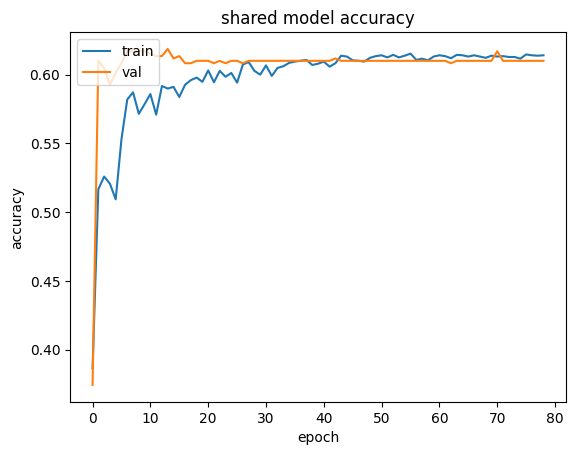

In [29]:
plot_shared(shared_history)

In [30]:
trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'shared_model.h5')
shared.save(trained_model)

c:\Users\20182009\Documents\Master DSAI\y2 q1\2IMI00 seminar process analytics\replicationStudy\.venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##### Load Saved Model and Evaluate

In [31]:
shared_trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'shared_model.h5')
shared_model = load_model(shared_trained_model)

In [32]:
x_test,y_test = generate_inputs_shared(vec_test,args,indexes)

print("Evaluate on test data")

results = shared_model.evaluate(x_test, y_test, batch_size=100)
y_pred_shared = shared_model.predict(x_test)
print("test loss, test acc:", results)

Evaluate on test data
52/52 [==============================] - 1s 3ms/step
test loss, test acc: [0.8320750594139099, 0.5895567536354065]


Classification Report

In [33]:
target_names = [index_ne[i] for i in range(len(index_ne))]

print(classification_report(y_test.argmax(axis=1), y_pred_shared.argmax(axis=1), target_names=target_names))

                                                  precision    recall  f1-score   support

    Request For Payment APPROVED by BUDGET OWNER       0.85      0.02      0.03       626
      Request For Payment APPROVED by SUPERVISOR       0.00      0.00      0.00         6
Request For Payment FINAL_APPROVED by SUPERVISOR       0.59      1.00      0.74       962
    Request For Payment REJECTED by BUDGET OWNER       0.00      0.00      0.00        13
      Request For Payment REJECTED by SUPERVISOR       0.00      0.00      0.00        40

                                        accuracy                           0.59      1647
                                       macro avg       0.29      0.20      0.15      1647
                                    weighted avg       0.66      0.59      0.45      1647



c:\Users\20182009\Documents\Master DSAI\y2 q1\2IMI00 seminar process analytics\replicationStudy\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\20182009\Documents\Master DSAI\y2 q1\2IMI00 seminar process analytics\replicationStudy\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\20182009\Documents\Master DSAI\y2 q1\2IMI00 seminar process analytics\replicationStudy\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-d

Confusion Matrix

[[ 11   0 615   0   0]
 [  0   0   6   0   0]
 [  2   0 960   0   0]
 [  0   0  13   0   0]
 [  0   0  40   0   0]]


<Axes: >

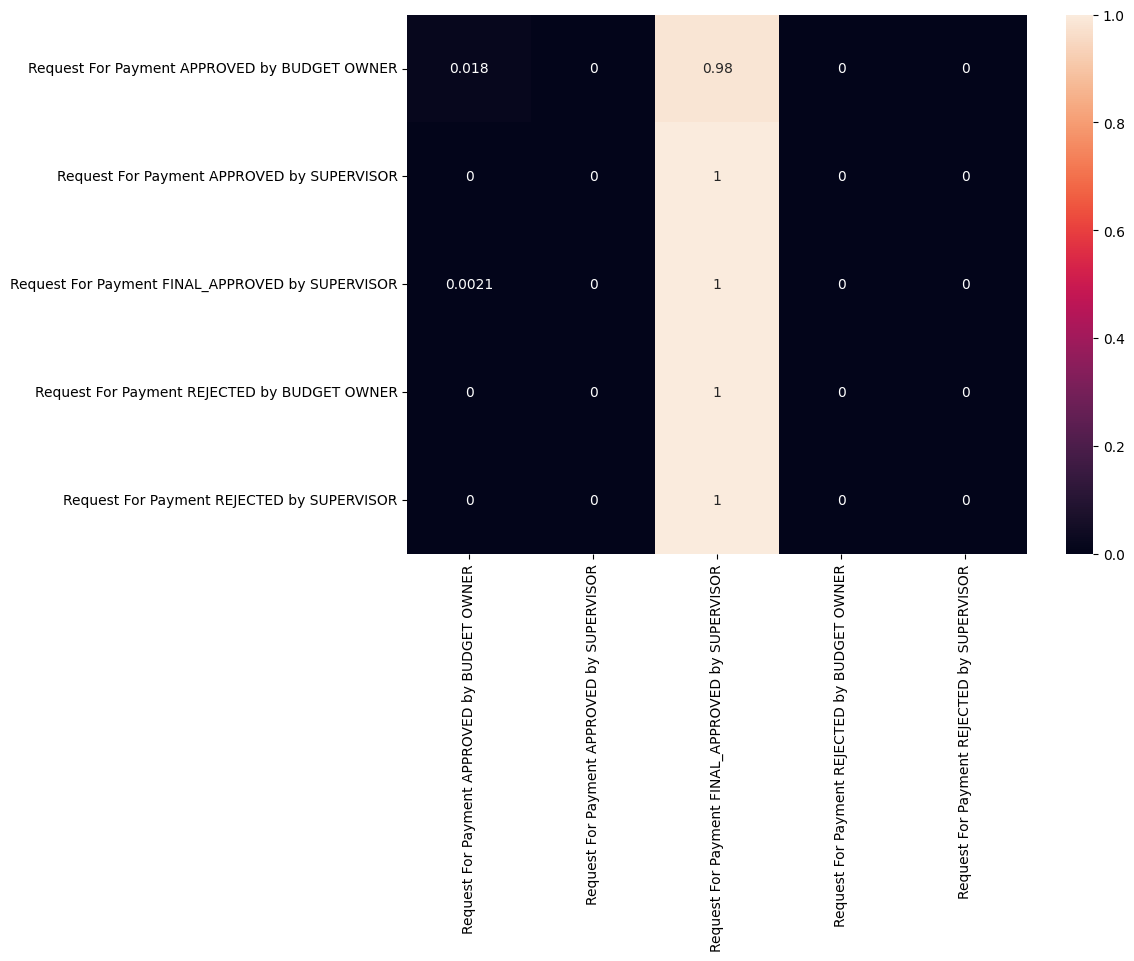

In [34]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_shared.argmax(axis=1))
print(matrix)
matrix_sum = np.sum(matrix, axis=1).reshape(-1,1)
matrix_perc = matrix / matrix_sum
df_cm = pd.DataFrame(matrix_perc, index = [index_ne[i] for i in range(len(index_ne))],
                  columns = [index_ne[i] for i in range(len(index_ne))])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

##### Generating Explanations with Attention Layer

In [35]:
shared_model_attn_weights = Model(inputs=shared_model.input,
              outputs=[shared_model.output, shared_model.get_layer('timestep_attention').output, shared_model.get_layer('feature_importance').output])

shared_output_with_attention = shared_model_attn_weights.predict(x_test)

52/52 [==============================] - 1s 4ms/step


In [36]:
shared_output_with_attention[2].shape

(1647, 5, 14)

### Global Explanations

In [37]:
shared_explain_global(shared_output_with_attention,x_test,y_test,index_ac,index_rl,3,prediction = 2 )

### Local Explanations

In [38]:
df_results_shared = results_df(y_test,y_pred_shared,index_ne)
df_results_shared [(df_results_shared ['prediction'] == 'O_SENT_BACK') & (df_results_shared ['pred_class'] == False) & (df_results_shared ['prediction_prob'] >=0.7) ].head(3)

,sample_index,prediction,ground_truth,prediction_prob,pred_class


In [39]:
shared_explain_local(shared_output_with_attention,x_test,y_test,index_ac, index_rl, index_ne, 3,53) #53 false, #1 true


prediction: Request For Payment FINAL_APPROVED by SUPERVISOR
ground truth: Request For Payment FINAL_APPROVED by SUPERVISOR
prediction probability:0.6109


process flowchart
st0=>start: start none_role:none
op1=>operation: none_role:none
op2=>operation: none_role:none
op3=>operation: Request For Payment APPROVED by ADMINISTRATION_role:ADMINISTRATION
op4=>operation: Request For Payment SUBMITTED by EMPLOYEE_role:EMPLOYEE

st0->op1
op1->op2
op2->op3
op3->op4





#### specialised Model

In [40]:
specialised = specialised_model(vec_train, weights, indexes, pre_index, args)


In [41]:
specialised.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [42]:
specialised.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 ac_input (InputLayer)       [(None, 5, 8)]               0         []                            
                                                                                                  
 rl_input (InputLayer)       [(None, 5, 5)]               0         []                            
                                                                                                  
 t_input (InputLayer)        [(None, 5, 1)]               0         []                            
                                                                                                  
 beta_ac (Bidirectional)     (None, 5, 100)               23600     ['ac_input[0][0]']            
                                                                                            

In [43]:
batch_size = 256 # 32, 64, 128, 256
epochs = 100

In [44]:
specialised_history = specialised_model_fit(vec_train, specialised, indexes, pre_index, MY_WORKSPACE_DIR, batch_size, epochs, args)

This is the output file path  c:\Users\20182009\Documents\Master DSAI\y2 q1\2IMI00 seminar process analytics\replicationStudy\Shared-and-Specialised-Attention-based-Interpretable-Models\BPIC20\models\model_specialised_Request For Payment APPROVED by ADMINISTRATION_{epoch:02d}-{val_loss:.2f}.h5
Epoch 1/100


13/13 [==============================] - 18s 277ms/step - loss: 1.5749 - accuracy: 0.4793 - val_loss: 1.5199 - val_accuracy: 0.6083 - lr: 0.0010
Epoch 2/100
13/13 [==============================] - 0s 37ms/step - loss: 1.4680 - accuracy: 0.6074 - val_loss: 1.3937 - val_accuracy: 0.6083 - lr: 0.0010
Epoch 3/100
13/13 [==============================] - 1s 67ms/step - loss: 1.3228 - accuracy: 0.6098 - val_loss: 1.2239 - val_accuracy: 0.6083 - lr: 0.0010
Epoch 4/100
13/13 [==============================] - 1s 40ms/step - loss: 1.1882 - accuracy: 0.6074 - val_loss: 1.1367 - val_accuracy: 0.6083 - lr: 0.0010
Epoch 5/100
13/13 [==============================] - 0s 36ms/step - loss: 1.1381 - accuracy: 0.6070 - val_loss: 1.0943 - val_accuracy: 0.6083 - lr: 0.0010
Epoch 6/100
13/13 [==============================] - 0s 35ms/step - loss: 1.1009 - accuracy: 0.6092 - val_loss: 1.0614 - val_accuracy: 0.6083 - lr: 0.0010
Epoch 7/100
13/13 [==============================] - 0s 35ms/step - loss: 1.0717

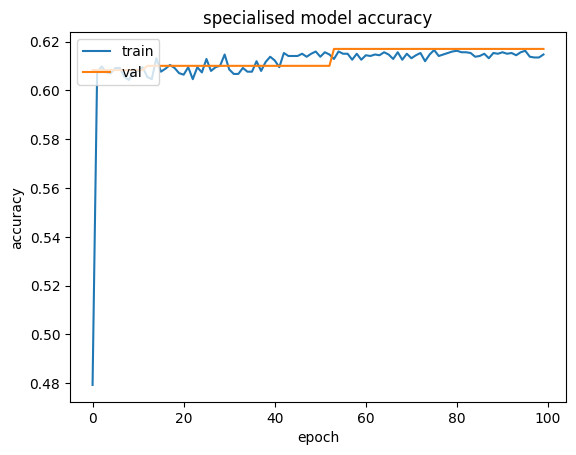

In [45]:
plot_specialised(specialised_history)

In [46]:
trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'specialised_model.h5')
specialised.save(trained_model)

c:\Users\20182009\Documents\Master DSAI\y2 q1\2IMI00 seminar process analytics\replicationStudy\.venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



##### Load Saved Model and Evaluate

In [47]:
trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'specialised_model.h5')
specialised_model = load_model(trained_model)

Evaluating Prediction Performance

In [48]:
# Generating Inputs

x_test_ohe,y_test = generate_inputs(vec_test,args,indexes,experiment)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")

results = specialised_model.evaluate(x_test_ohe, y_test, batch_size=100)
y_pred = specialised_model.predict(x_test_ohe)
print("test loss, test acc:", results)

Evaluate on test data
52/52 [==============================] - 3s 4ms/step
test loss, test acc: [0.8344704508781433, 0.5925925970077515]


In [49]:
target_names = [index_ne[i] for i in range(len(index_ne))]

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=target_names))

                                                  precision    recall  f1-score   support

    Request For Payment APPROVED by BUDGET OWNER       0.79      0.03      0.06       626
      Request For Payment APPROVED by SUPERVISOR       0.00      0.00      0.00         6
Request For Payment FINAL_APPROVED by SUPERVISOR       0.59      0.99      0.74       962
    Request For Payment REJECTED by BUDGET OWNER       0.00      0.00      0.00        13
      Request For Payment REJECTED by SUPERVISOR       0.00      0.00      0.00        40

                                        accuracy                           0.59      1647
                                       macro avg       0.28      0.21      0.16      1647
                                    weighted avg       0.65      0.59      0.45      1647



c:\Users\20182009\Documents\Master DSAI\y2 q1\2IMI00 seminar process analytics\replicationStudy\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\20182009\Documents\Master DSAI\y2 q1\2IMI00 seminar process analytics\replicationStudy\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\20182009\Documents\Master DSAI\y2 q1\2IMI00 seminar process analytics\replicationStudy\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

Confusion Matrix

[[ 19   0 607   0   0]
 [  0   0   6   0   0]
 [  5   0 957   0   0]
 [  0   0  13   0   0]
 [  0   0  40   0   0]]


<Axes: >

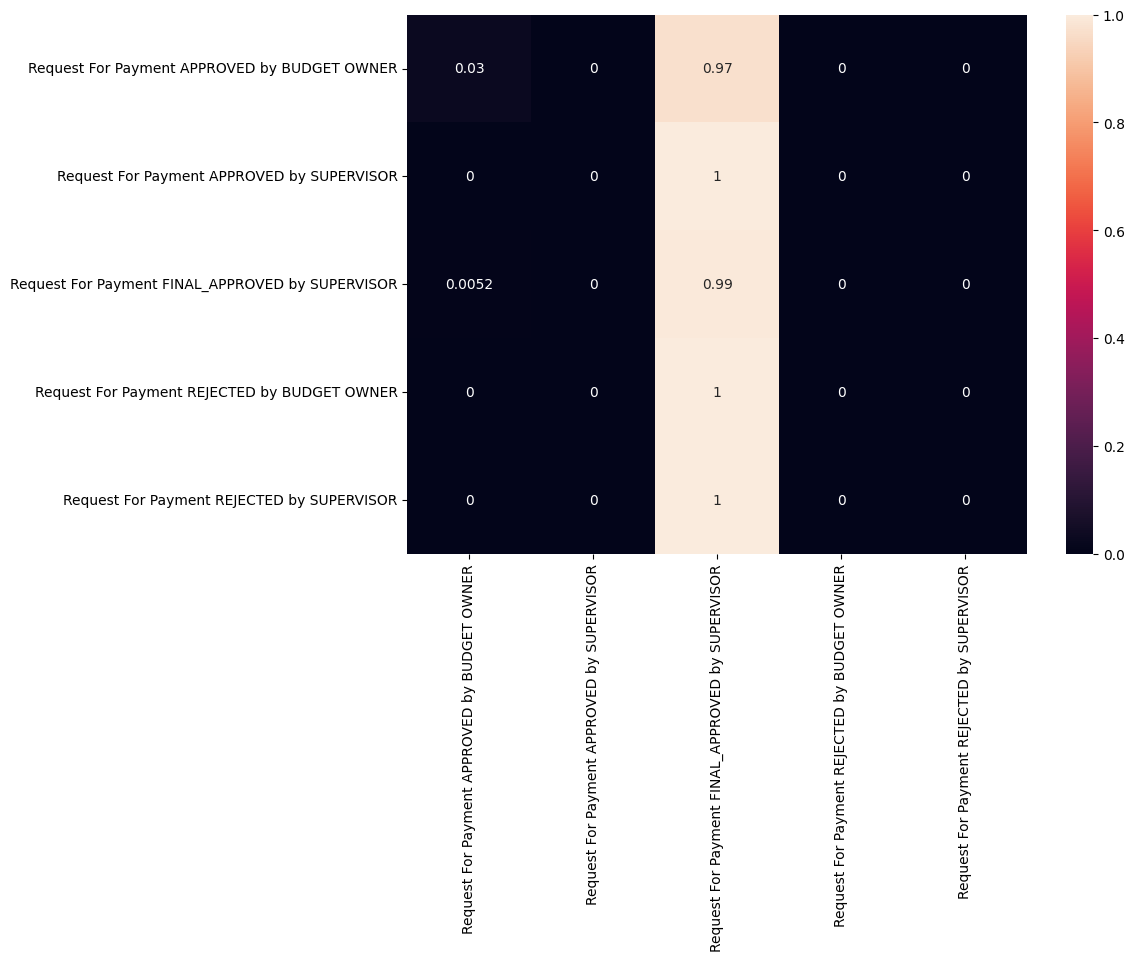

In [50]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)
matrix_sum = np.sum(matrix, axis=1).reshape(-1,1)
matrix_perc = matrix / matrix_sum
df_cm = pd.DataFrame(matrix_perc, index = [index_ne[i] for i in range(len(index_ne))],
                  columns = [index_ne[i] for i in range(len(index_ne))])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

##### Generating Explanations with Attention Layer

In [51]:
model_attn_weights = Model(inputs=specialised_model.input,
              outputs=[specialised_model.output, specialised_model.get_layer('timestep_attention').output,specialised_model.get_layer('ac_importance').output ,specialised_model.get_layer('rl_importance').output,specialised_model.get_layer('t_importance').output])

output_with_attention = model_attn_weights.predict(x_test_ohe)

52/52 [==============================] - 3s 7ms/step


In [52]:
output_with_attention[4].shape

(1647, 5, 1)

In [53]:
print(index_rl)

{0: 'none', 1: 'ADMINISTRATION', 2: 'BUDGET OWNER', 3: 'EMPLOYEE', 4: 'SUPERVISOR'}


In [54]:
explain_global(output_with_attention,x_test,y_test,index_ac, index_rl,3,prediction=2)

###### Local Explanations

In [55]:
df_results = results_df(y_test,y_pred,index_ne)
df_results [(df_results ['prediction'] == 'W_Assessing the application') & (df_results ['pred_class'] == True) & (df_results ['prediction_prob'] >=0.7) ].head(3)

,sample_index,prediction,ground_truth,prediction_prob,pred_class


In [56]:
explain_local(output_with_attention,x_test,y_test,index_ac,index_rl,index_ne,3,53)

prediction: Request For Payment FINAL_APPROVED by SUPERVISOR
ground truth: Request For Payment FINAL_APPROVED by SUPERVISOR
prediction probability:0.6133


process flowchart
st6=>start: start none
op7=>operation: none_none
op8=>operation: none_none
op9=>operation: Request For Payment APPROVED by ADMINISTRATION_ADMINISTRATION
op10=>operation: Request For Payment SUBMITTED by EMPLOYEE_EMPLOYEE

st6->op7
op7->op8
op8->op9
op9->op10



